In [1]:
# Import libraries
import os, random, numpy as np, matplotlib.pyplot as plt, seaborn as sns, cv2
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Replace these paths with the correct paths from your Google Drive
train_path = "/content/drive/My Drive/archive.zip/train"
valid_path = "/content/drive/My Drive/archive.zip/valid"
test_path  = "/content/drive/My Drive/archive.zip/test"

In [4]:
import zipfile
import os

# Path to your zip file in Drive
zip_path = "/content/drive/My Drive/archive.zip"

# Extract to /content/dataset
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)


Extracted to: /content/dataset


In [5]:
train_path = "/content/dataset/Retinal Fundus Images/train"
valid_path = "/content/dataset/Retinal Fundus Images/val"   # <-- val, not valid
test_path  = "/content/dataset/Retinal Fundus Images/test"

import os
print("Train samples:", len(os.listdir(train_path)))
print("Valid samples:", len(os.listdir(valid_path)))
print("Test samples:", len(os.listdir(test_path)))


Train samples: 7
Valid samples: 7
Test samples: 7


In [6]:
# Define dataset paths and parameters
DATASET_ROOT = "dataset/Retinal Fundus Images"   # update if your dataset path differs
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

print("Dataset Path:", DATASET_ROOT)

Dataset Path: dataset/Retinal Fundus Images


In [8]:
train_dir = "dataset/Retinal Fundus Images/train"
val_dir = "dataset/Retinal Fundus Images/val"
test_dir = "dataset/Retinal Fundus Images/test"

train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Classes found:", train_data.class_indices)


Found 55446 images belonging to 7 classes.
Found 433 images belonging to 7 classes.
Found 1236 images belonging to 7 classes.
Classes found: {'AMD': 0, 'Cataract': 1, 'DR': 2, 'Glaucoma': 3, 'Hypertensive_Retinopathy': 4, 'Normal_Fundus': 5, 'Pathological_Myopia': 6}


In [9]:
# Define a simple Multi-Head Self-Attention mechanism for feature refinement
from tensorflow.keras.layers import MultiHeadAttention, Add, LayerNormalization, Dense

def self_attention_block(x, num_heads=8, key_dim=64):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(x.shape[-1]*2, activation='relu')(x)
    ff = Dense(x.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)
    return x

In [10]:
#Step 6: Build ResNet50 + Multi-Head Self-Attention model for multi-class retinal disease classification

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

# Define constants
IMG_SIZE = (224, 224)
NUM_CLASSES = 7  # AMD, Cataract, DR, Glaucoma, Hypertensive_Retinopathy, Normal_Fundus, Pathological_Myopia

#Define a self-attention block (multi-head attention)
def self_attention_block(x, num_heads=4, key_dim=64):
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attention])  # residual connection
    x = layers.LayerNormalization()(x)

    # Feed-forward layer inside attention
    ffn = layers.Dense(512, activation='relu')(x)
    ffn = layers.Dropout(0.2)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)

    # Second residual connection
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)
    return x

#Build the ResNet50 base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base_model.layers:
    layer.trainable = False  # freeze convolutional base for transfer learning

#Build the custom head with attention
inp = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inp, training=False)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Reshape the CNN feature maps for attention
x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)

# Apply multiple self-attention blocks
x = self_attention_block(x)
x = self_attention_block(x)

# Global pooling and classification head
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)

# Output layer for 7-class classification
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

#Build and compile the final model
model = models.Model(inputs=inp, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Summary of the model
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 512) │  9,437,696 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 512) │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 512)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 512)   │    525,568 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 512)   │          0 │ reshape[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 49, 512)   │      1,024 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 49, 512)   │    262,656 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 49, 512)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 49, 512)   │    262,656 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 49, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 512)   │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 512)   │    525,568 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 49, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 512)   │      1,024 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 49, 512)   │    262,656 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 49, 512)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 49, 512)   │    262,656 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 35,399,559 (135.04 MB)

 Trainable params: 11,810,823 (45.05 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [11]:
# Define callbacks for training stability
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

In [12]:
# Train with frozen backbone (attention + classifier layers)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4247 - loss: 1.5130

3466/3466 ━━━━━━━━━━━━━━━━━━━━ 1061s 298ms/step - accuracy: 0.4247 - loss: 1.5130 - val_accuracy: 0.6259 - val_loss: 1.0262 - learning_rate: 1.0000e-04
Epoch 2/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 979s 282ms/step - accuracy: 0.5427 - loss: 1.2270 - val_accuracy: 0.6236 - val_loss: 1.0771 - learning_rate: 1.0000e-04
Epoch 3/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.5769 - loss: 1.1414

3466/3466 ━━━━━━━━━━━━━━━━━━━━ 953s 275ms/step - accuracy: 0.5769 - loss: 1.1414 - val_accuracy: 0.6952 - val_loss: 0.9265 - learning_rate: 1.0000e-04
Epoch 4/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 953s 275ms/step - accuracy: 0.5939 - loss: 1.1000 - val_accuracy: 0.6051 - val_loss: 1.1830 - learning_rate: 1.0000e-04
Epoch 5/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 951s 274ms/step - accuracy: 0.6041 - loss: 1.0737 - val_accuracy: 0.6328 - val_loss: 0.9963 - learning_rate: 1.0000e-04
Epoch 6/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 949s 274ms/step - accuracy: 0.6171 - loss: 1.0444 - val_accuracy: 0.5704 - val_loss: 1.2939 - learning_rate: 1.0000e-04
Epoch 7/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 944s 272ms/step - accuracy: 0.6454 - loss: 0.9737 - val_accuracy: 0.6305 - val_loss: 1.0427 - learning_rate: 3.0000e-05
Epoch 8/20
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 944s 272ms/step - accuracy: 0.6543 - loss: 0.9405 - val_accuracy: 0.6305 - val_loss: 1.0880 - learning_rate: 3.0000e-05


In [13]:
# Unfreeze last 50 layers of ResNet for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile again with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training (fine-tuning)
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/10
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 1019s 284ms/step - accuracy: 0.4805 - loss: 1.4992 - val_accuracy: 0.6305 - val_loss: 1.1034 - learning_rate: 1.0000e-05
Epoch 2/10
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 965s 278ms/step - accuracy: 0.6021 - loss: 1.0879 - val_accuracy: 0.6490 - val_loss: 0.9564 - learning_rate: 1.0000e-05
Epoch 3/10
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 967s 279ms/step - accuracy: 0.6289 - loss: 1.0070 - val_accuracy: 0.6674 - val_loss: 0.9596 - learning_rate: 1.0000e-05
Epoch 4/10
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 967s 279ms/step - accuracy: 0.6554 - loss: 0.9374 - val_accuracy: 0.6721 - val_loss: 0.9215 - learning_rate: 1.0000e-05
Epoch 5/10
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 963s 278ms/step - accuracy: 0.6814 - loss: 0.8858 - val_accuracy: 0.6467 - val_loss: 1.0098 - learning_rate: 1.0000e-05
Epoch 6/10
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 967s 279ms/step - accuracy: 0.6963 - loss: 0.8404 - val_accuracy: 0.6928 - val_loss: 0.8393 - learning_rate: 1.0000e-05
Epoch 7/10
3466/3466 ━━━━━━

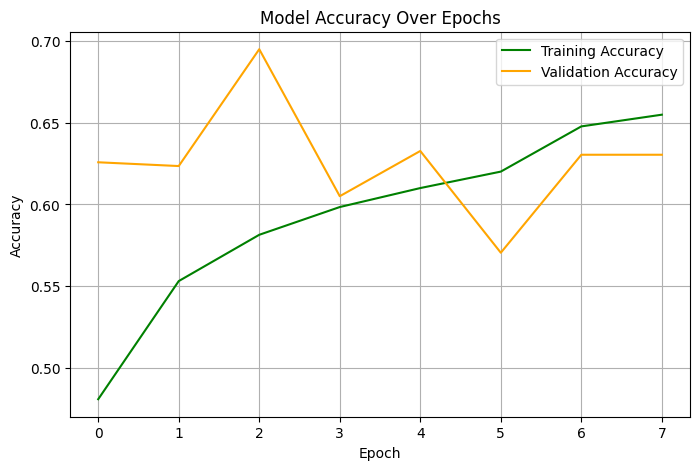

In [14]:
#Plot Training and Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


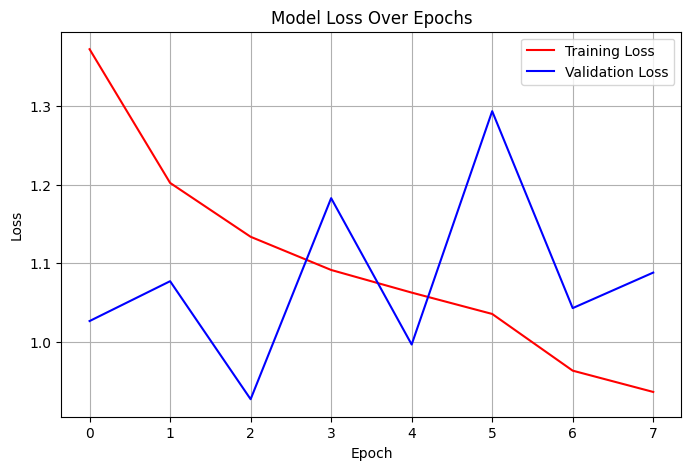

In [15]:
#Plot Training and Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.8085 - loss: 0.5583

Test Accuracy: 75.16%
Test Loss: 0.6710
78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step


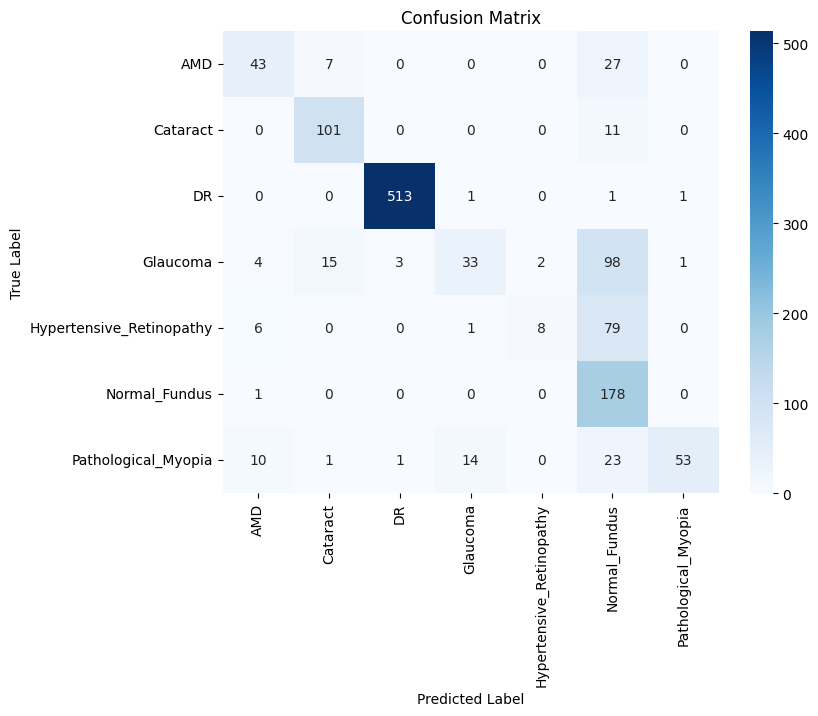


Classification Report:

                          precision    recall  f1-score   support

                     AMD       0.67      0.56      0.61        77
                Cataract       0.81      0.90      0.86       112
                      DR       0.99      0.99      0.99       516
                Glaucoma       0.67      0.21      0.32       156
Hypertensive_Retinopathy       0.80      0.09      0.15        94
           Normal_Fundus       0.43      0.99      0.60       179
     Pathological_Myopia       0.96      0.52      0.68       102

                accuracy                           0.75      1236
               macro avg       0.76      0.61      0.60      1236
            weighted avg       0.82      0.75      0.72      1236


Cohen’s Kappa Score: 0.671


In [16]:
# --- Model Evaluation & Performance Summary ---

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# 1. Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# 2. Generate predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 5. Cohen’s Kappa Score
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f"\nCohen’s Kappa Score: {kappa:.3f}")